# 

[Insprired by](https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542), see also chapter 6.5 of Sutton etal. 

- https://towardsdatascience.com/simple-reinforcement-learning-q-learning-fcddc4b6fe56
- https://en.wikipedia.org/wiki/Q-learning
- https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/

In [1]:
from support_functions import *
import numpy as np
import dill
import itertools

print('Loading tree...')
with open('tree_tctoe_3x3.pkl', 'rb') as f:
    tree = dill.load(f)

print('Precomputing best moves...')
all_states = []
for length in range(1,9):
    tree_states = [''.join(state) for state in list(itertools.permutations(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'], r=length))]
    all_states.extend(tree_states)

for state in tqdm(all_states):
    try:
        move = determine_move(tree, state, False) 
    except:
        pass 

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Loading tree...


  0%|          | 0/623529 [00:00<?, ?it/s]

Precomputing best moves...


100%|██████████| 623529/623529 [00:59<00:00, 10567.92it/s] 


In [6]:
determine_move(tree, 'a', False)

'e'

# Make the Q-table

# Training against self

100%|██████████| 10000/10000 [00:08<00:00, 1173.98it/s]




2155
2072


<AxesSubplot:>

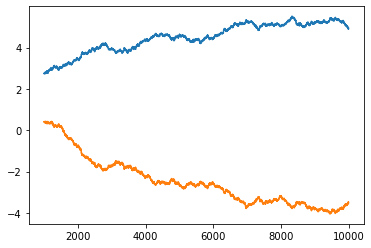

In [2]:
player1 = Player_vs_itself(1, 
                 alpha = 0.1, 
                 gamma = 0.9,
                 epsilon = 0.1)
player2 = Player_vs_itself(-1, 
                 alpha = 0.1,
                 gamma = 0.9, 
                 epsilon = 0.4)

# Training the policy
player1, player2, p1_rewards, p2_rewards, paths = play_tictactoe_vs_itself(10000, player1, player2, verbose=False)
print('\n')
print(len(player1.get_qtable()))
print(len(player2.get_qtable()))
pd.Series(p1_rewards).rolling(1000).mean().plot()
pd.Series(p2_rewards).rolling(1000).mean().plot()

In [ ]:
player1.get_qtable()

In [14]:
with open('player1.pkl', 'wb') as f:
    dill.dump(player1, f)

### Validation against self

100%|██████████| 1000/1000 [00:00<00:00, 1281.08it/s]


<AxesSubplot:>

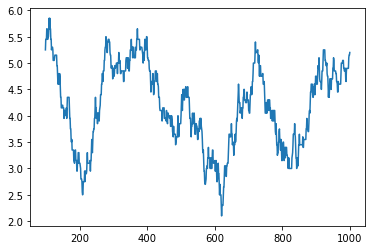

In [8]:
# Validating the model. Setting epsilon to 0 ensures always using the optimal strategy

player1.set_params(epsilon = 0)
random_player = Player(1, epsilon=1.0)
player2.set_params(epsilon = 0)

player1, player2, p1_rewards, p2_rewards, paths = play_tictactoe(1000, player1, player2, verbose=False)
pd.Series(p1_rewards).rolling(100).mean().plot()

### Validation against tree

100%|██████████| 1000/1000 [00:00<00:00, 1180.52it/s]


<AxesSubplot:>

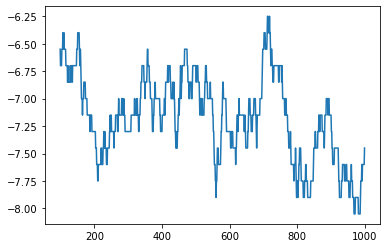

In [7]:
tictactoe = Tictoe(3)
player_solo_tree = Player_tree(tree, -1)
player1.set_params(epsilon = 0)

no_episodes = 1000
rewards = np.zeros(no_episodes)
for ep_idx in tqdm(range(no_episodes)):
    #print(ep_idx)
    while not tictactoe.is_endstate():
        tictactoe = player1.make_move(tictactoe, False)
        #print(tictactoe.get_board())
        if not tictactoe.is_endstate():
            tictactoe.make_move(-1, player_solo_tree.make_move(tictactoe.get_moves_made()))
        #print(tictactoe.get_board())
    rewards[ep_idx] = tictactoe.get_reward(1)
    tictactoe.reset_board()
pd.Series(rewards).rolling(100).mean().plot()

# Training against tree

In [3]:
tictactoe = Tictoe(3)
player_tree = Player_vs_tree(1,
                            alpha = 0.01,
                            gamma = 0.8,
                            epsilon = 0.1)

no_episodes = 1000
rewards = np.zeros(no_episodes)
for ep_idx in tqdm(range(no_episodes)):
    while not tictactoe.is_endstate():
        tictactoe = player_tree.make_move(tictactoe, False)
    rewards[ep_idx] = tictactoe.get_reward(1)
    tictactoe.reset_board()

Loading tree...


  0%|          | 0/623529 [00:00<?, ?it/s]

Precomputing best moves...


100%|██████████| 1000/1000 [00:00<00:00, 1311.44it/s]


<AxesSubplot:>

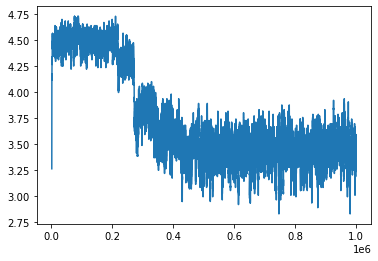

In [69]:
pd.Series(rewards).rolling(1000).mean().plot()

In [ ]:
player_tree.get_qtable()

In [135]:
with open('well_tree_trained_rl_agent.pkl', 'wb') as f:
    tree = dill.dump(player_tree, f)

# Validate against tree

In [ ]:
print('Loading tree...')
with open('tree_tctoe_3x3.pkl', 'rb') as f:
    tree = dill.load(f)

100%|██████████| 10000/10000 [00:09<00:00, 1064.58it/s]


<AxesSubplot:>

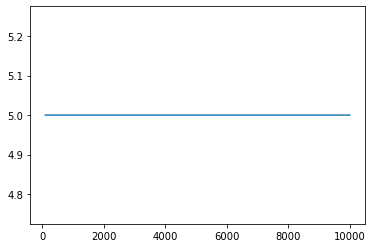

In [129]:
tictactoe = Tictoe(3)
player_solo_tree = Player_tree(tree, -1)
player_tree.set_params(epsilon = 0)

no_episodes = 10000
rewards = np.zeros(no_episodes)
for ep_idx in tqdm(range(no_episodes)):
    #print(ep_idx)
    while not tictactoe.is_endstate():
        tictactoe = player_tree.make_move(tictactoe, False)
        #print(tictactoe.get_board())
        if not tictactoe.is_endstate():
            tictactoe.make_move(-1, player_solo_tree.make_move(tictactoe.get_moves_made()))
        #print(tictactoe.get_board())
    rewards[ep_idx] = tictactoe.get_reward(1)
    tictactoe.reset_board()
pd.Series(rewards).rolling(100).mean().plot()

100%|██████████| 10000/10000 [00:06<00:00, 1604.30it/s]


<AxesSubplot:>

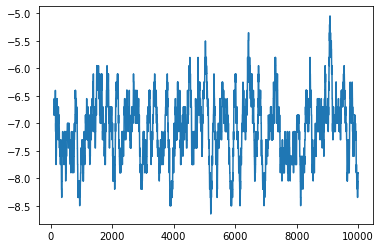

In [128]:
tictactoe = Tictoe(3)
player_solo_tree = Player_tree(tree, -1)
player_tree.set_params(epsilon = 0)  # <---- play randomly

no_episodes = 10000
rewards = np.zeros(no_episodes)
for ep_idx in tqdm(range(no_episodes)):
    #print(ep_idx)
    while not tictactoe.is_endstate():
        tictactoe.make_move(1, random.choice(tictactoe.get_possible_next_moves()))
        #print(tictactoe.get_board())
        if not tictactoe.is_endstate():
            tictactoe.make_move(-1, player_solo_tree.make_move(tictactoe.get_moves_made()))
        #print(tictactoe.get_board())
    rewards[ep_idx] = tictactoe.get_reward(1)
    tictactoe.reset_board()
pd.Series(rewards).rolling(100).mean().plot()

#### Manual play

In [132]:
tictactoe = Tictoe(3)

print('''Welcome to TicTacToe. 

You can make a move by selecting one of the following letters:''')
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
print(np.array(letters).reshape(3,3))
print('''You start, the computer will take the next move

Initial board:''')

player_tree.set_params(epsilon = 0)
move_history = ''
while not tictactoe.is_endstate():
    print('Computer is thinking')
    tictactoe = player_tree.make_move(tictactoe, verbose=True)
    print(tictactoe.get_board())
    
    if not tictactoe.is_endstate():
        player_move = input('Your move!: ')
        tictactoe.make_move(-1, player_move)
        print(tictactoe.get_board())

Welcome to TicTacToe. 

You can make a move by selecting one of the following letters:
[['a' 'b' 'c']
 ['d' 'e' 'f']
 ['g' 'h' 'i']]
You start, the computer will take the next move

Initial board:
Computer is thinking
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]


Your move!:  a


[[-1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  0.]]
Computer is thinking
[[-1.  0.  0.]
 [ 1.  1.  0.]
 [ 0.  0.  0.]]


Your move!:  f


[[-1.  0.  0.]
 [ 1.  1. -1.]
 [ 0.  0.  0.]]
Computer is thinking
[[-1.  0.  1.]
 [ 1.  1. -1.]
 [ 0.  0.  0.]]


Your move!:  g


[[-1.  0.  1.]
 [ 1.  1. -1.]
 [-1.  0.  0.]]
Computer is thinking
[[-1.  0.  1.]
 [ 1.  1. -1.]
 [-1.  0.  1.]]


Your move!:  b


[[-1. -1.  1.]
 [ 1.  1. -1.]
 [-1.  0.  1.]]


# Insights tijdens dev

- Ik begon met een state die afhankelijk was van de volgorde waarin je op die state uitkwam. De key was dan bv 'ebad'. Maar we willen eigenlijk helemaal niet. Het probleem is hier dat we dan een veel te grote state space krijgen, en alleen maar gaan leren als we specifiek op die bepaalde stand op het bord komen via een specifieke route. Nu kijken we alleen naar stand op het bord. 
- Hash algo 'str' is erg traag, 3x penalty in performance. -> gebruiken van hashlib en sha1 was 3x sneller
- De learning rate had ik erg hoog. -> maakt vs tree schijnbaar niet zoveel uit
- Paden bijhouden levert veel op qua inzicht in wat er precies gebeurt
- Ik begon met alleen leren op de eigen qtable. Maar we leren met twee agents tegelijkertijd. Dus we moeten ook de rewards van de andere player kunnen inzien. Daar moeten we dan minmax achtig op reageren, i.e. als hij hoog scoort dan geeft die state een negatieve reward. 
- Uiteindelijk ben ik overgestapt op leren tregen de tree. Dit maakt het meer een traditioneel RL probleem, ik gooi acties tegen de werkelijkheid aan (de tree) en krijg terug of ik het goed doe. 

# Nog te doen
- Trainen tegen betere tegenstander, tegen zichzelf is wel shit. Bijvoorbeeld de treesearch die we eerder maakten. Of een soort bootstrap. 
    - Geprobeerd: player 2 een hogere epsilon. Dan speelt nr1 tegen een meer random tegenstander. 
    - Spelen tegen de tree werkt goed. We gaan van ingemaakt worden naar het erg goed doen. 
- Meer optimale hash code, [bv deze](https://stackoverflow.com/questions/806151/how-to-hash-a-large-object-dataset-in-python/806342#806342)
- Wat verkennend werk doen rondom de hyperparams alpha, gamma en epsilon. 
    - dit lijkt niet veel uit te maken
- Betere validatie dan weer tegen zichzelf. Bv tegen de treesearch zou goed zijn. 
    - Validatie met de tree laat zien dat de RL-agent het beter dan een random agent doet. 
    - Helaas opent de RL-agent altijd met dezelfde zet, waarbij de volgende zet door de tree ook vaststaat. En je krijgt dus altijd het zelfde potje. 
    - De agent getrained tegen de tree zelf doet het erg goed

\begin{equation}
Q^{new}(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha (r_t + \gamma \cdot \max_a(s_{t+1}, a) - Q(s_t, a_t))
\end{equation}

where:

- $Q^{new}(s_t, a_t)$, is the new Q-value for the given action-value pair for state $s_t$ and action $a_t$. 
- $Q(s_t, a_t)$, the previous Q-value that was recorded in the Q-table.
- $\alpha$ the learning rate. How heavily should the new Q-value be influenced by what we are going to learn in this new step?
- $r_t$ the (short-term) reward we got for taking the $\epsilon$-greedy step. 
- $max_a(s_{t+1}, a)$ is the estimate of optimal future value for state $s_{t+1}$, i.e. the maximum Q value for that state $s_{t+1}$. 

A slight rewrite of the function yields additional insight:

\begin{equation}
Q^{new}(s_t, a_t) \leftarrow (1-\alpha) Q(s_t, a_t) + \alpha r_t + \alpha\gamma \max_a(s_{t+1}, a)
\end{equation}

where:
- $(1-\alpha) Q(s_t, a_t)$ is the current value of Q weighted by the learning rate. So, if the learning rate is zero, the new value is simply the old value. This essentially means the algorithm is not learning anything new. An alpha value of 1 simply discards this old value and completely relies on the new Q value calculated by the other terms. Values in between 0 and 1 allow you to control how fast learning progresses. A balance between learning fast enough, but not getting overly focused on short term gains is part of the challenge. 
- $\alpha r_t$ the short-term reward we got from taking the $\epsilon$-greedy action we took. Like before, an $\alpha$ of 1 ensures completely focusing on the short-term reward, and an $\alpha$ of 0 completely disregards what reward we got. 
- $\alpha\gamma \max_a(s_{t+1}, a)$ the largest potential future Q-value we could obtain in the actions that follow this particular state. It hints towards the potential (long-term) value taking action $a_t$ in state $s_t$. 

So, to update the value $Q$ of taking action $a_t$ given a state $s_t$ we balance the old value we got versus the short term reward and the potential long-term value the next steps after this action provides. 